In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data

In [2]:
#btc options data
df=pd.read_csv('data/data.csv', sep=",", index_col=0)
#df.drop(columns=['Unnamed: 0', 'interest_rate'], inplace=True)
btc_data = df   

In [3]:
df["Time to Expiration"].describe()

count    584.000000
mean       0.429171
std        0.275073
min        0.082192
25%        0.158904
50%        0.408219
75%        0.657534
max        0.906849
Name: Time to Expiration, dtype: float64

### Reverse BSM approach 

In [20]:
# Importing necessary libraries for calculations and to check if VolLib or an efficient library is available.
# Since we can't import VolLib directly, I'll use scipy to calculate implied volatility.

from scipy.stats import norm
import numpy as np

#adjust and set to any 
interest_rate = 0.05

# Define the Black-Scholes formula for option pricing
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes option price for a given option type (call or put)."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be either 'call' or 'put'")
    return price

# Define a function to calculate implied volatility by minimizing the error between market and theoretical price
from scipy.optimize import brentq

def implied_volatility(price, S, K, T, r, option_type='call'):
    """Calculate implied volatility using the Black-Scholes model."""
    def objective_function(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - price
    
    try:
        iv = brentq(objective_function, 1e-6, 4.0)  # bounds to search for volatility
    except ValueError:
        iv = np.nan  # if it doesn't converge
    return iv

# Preparing data for calculation
# Extracting necessary columns: underlying_price, Strike Price, Time to Expiration, interest_rate, mark_price
btc_data['implied_volatility'] = btc_data.apply(
    lambda row: implied_volatility(
        price=row['mark_price'],
        S=row['underlying_price'],
        K=row['Strike Price'],
        T=row['Time to Expiration'],
        r=interest_rate,
        option_type='call'  # Assuming call options for simplicity; adjust as needed.
    ), axis=1
)

In [7]:
btc_data['implied_volatility'].isnull().sum()

172

In [8]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata


# Define the columns needed from your data
strikes = btc_data['Strike Price'].values
times_to_expiration = btc_data['Time to Expiration'].values
implied_vols = btc_data['implied_volatility'].values

# Create meshgrid for strikes and times_to_expiration
X, Y = np.meshgrid(np.unique(strikes), np.unique(times_to_expiration))

# Interpolate the implied volatilities to fill the grid
Z = griddata((strikes, times_to_expiration), implied_vols, (X, Y), method='linear')

# Create the interactive 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

fig.update_layout(
    title='Implied Volatility Surface (VEGA Approach)',
    autosize=False,
    width=800,
    height=700,
    scene=dict(
        xaxis_title='Strike Price',
        yaxis_title='Time to Expiry (Years)',
        zaxis_title='Implied Volatility %',
        xaxis=dict(type="log")
    )
)

fig.show()


### Vega-Based Iterative Approach  

In [9]:
import numpy as np
from scipy.stats import norm

# Define functions for the Black-Scholes model, Vega, and implied volatility calculation


#adjust and set to any 
interest_rate = 0.05

def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    """
    Calculate Black-Scholes option price for call or put options.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
        
    return price

def vega(S, K, T, r, sigma):
    """
    Calculate Vega, the sensitivity of the option price to changes in volatility.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def implied_volatility(market_price, S, K, T, r, initial_vol, option_type="call", tolerance=1e-5, max_iterations=100):
    """
    Calculate implied volatility using the Newton-Raphson method.
    """
    sigma = initial_vol
    for i in range(max_iterations):
        price = black_scholes_price(S, K, T, r, sigma, option_type)
        vega_value = vega(S, K, T, r, sigma)
        
        # If vega is very small, avoid division by zero or insignificant changes
        if vega_value < 1e-5:
            break
        
        # Update sigma
        price_difference = market_price - price
        sigma += price_difference / vega_value
        
        # Check for convergence
        if abs(price_difference) < tolerance:
            return sigma
    
    # Return None if no convergence (indicating potential calculation issue)
    return None

# Apply the implied volatility function to the data
results = []
for index, row in btc_data.iterrows():
    S = row['underlying_price']
    K = row['Strike Price']
    T = row['Time to Expiration']
    r = interest_rate
    market_price = row['mark_price']
    initial_vol = row['mark_iv'] / 100  # Assuming mark_iv is in percentage

    # Calculate implied volatility
    iv = implied_volatility(market_price, S, K, T, r, initial_vol, option_type="call")
    results.append(iv)

# Add the results to the DataFrame
btc_data['calculated_implied_volatility'] = results

C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_8040\2410460830.py:10: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_8040\2410460830.py:26: RuntimeWarning:

divide by zero encountered in scalar divide



In [10]:
btc_data['calculated_implied_volatility'].describe()


count    408.000000
mean       0.421798
std        0.341645
min        0.006688
25%        0.174955
50%        0.338562
75%        0.582857
max        1.877748
Name: calculated_implied_volatility, dtype: float64

In [11]:
btc_data['implied_volatility'].describe()

count    412.000000
mean       0.420234
std        0.341262
min        0.006688
25%        0.172671
50%        0.338562
75%        0.576748
max        1.877748
Name: implied_volatility, dtype: float64

In [12]:
btc_data['calculated_implied_volatility'].isnull().sum()

176

In [16]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata


# Define the columns needed from your data
strikes = btc_data['Strike Price'].values
times_to_expiration = btc_data['Time to Expiration'].values
implied_vols = btc_data['calculated_implied_volatility'].values

# Create meshgrid for strikes and times_to_expiration
X, Y = np.meshgrid(np.unique(strikes), np.unique(times_to_expiration))

# Interpolate the implied volatilities to fill the grid
Z = griddata((strikes, times_to_expiration), implied_vols, (X, Y), method='linear')

# Create the interactive 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

fig.update_layout(
    title='Implied Volatility Surface (VEGA Approach)',
    autosize=False,
    width=800,
    height=700,
    scene=dict(
        xaxis_title='Strike Price',
        yaxis_title='Time to Expiry (Years)',
        zaxis_title='Implied Volatility %',
        xaxis=dict(type="log")
    )
)

fig.show()


### Debribit Mark_IV

In [14]:
df=pd.read_csv('data/data.csv', sep=",", index_col=0)

# Converting "mark_iv" column to a percentage scale between 0 and 1 by dividing by 100
df['mark_iv_percentage'] = btc_data['mark_iv'] / 100

In [19]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Define the spot price and percentage limits
spot_price = df['underlying_price'].mean()  # Assuming a spot price column exists

# Extract relevant data for the surface plot
strikes = df['Strike Price'].values
times_to_expiration = df['Time to Expiration'].values
implied_vols = df['mark_iv_percentage'].values

# Create meshgrid for strikes and times_to_expiration
X, Y = np.meshgrid(np.unique(strikes), np.unique(times_to_expiration))

# Interpolate the implied volatilities to fill the grid
Z = griddata((strikes, times_to_expiration), implied_vols, (X, Y), method='linear')

# Create the interactive 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

fig.update_layout(title='Implied Volatility Surface Debribit Mark_IV', autosize=False,
                  width=700, height=700,
                  scene=dict(
                      xaxis_title='Strike Price',
                      yaxis_title='Time to Expiry',
                      zaxis_title='Implied Volatility'))
fig.show()


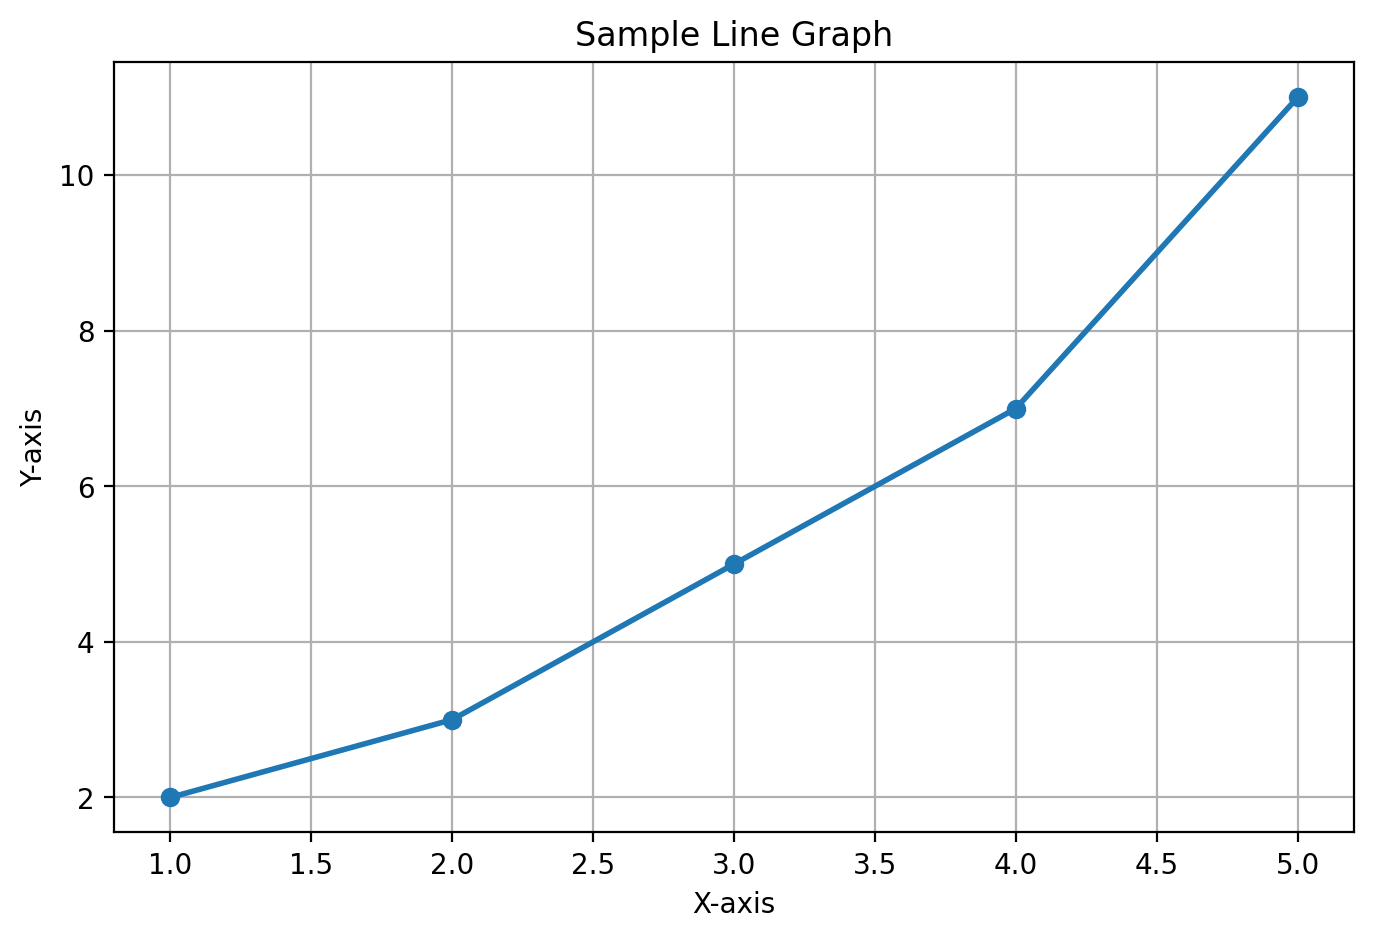

In [17]:
import matplotlib.pyplot as plt

# Sample data for the line graph
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]

# Create a line plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', linewidth=2)
plt.title("Sample Line Graph")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()
